In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
from Bio import SeqIO
from Bio.Data import CodonTable
from Bio.Seq import Seq
from Bio.SeqUtils import seq3
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import TransformedBbox
import re
from scipy.stats import mannwhitneyu, spearmanr
from tqdm import tqdm

#set to true to reverse complement codons in codon table (heatmap part only! fracs have the same trigger in calculate_aa_fracs.py)
REV_COMP = False

# AA Fracs

### Positive genes


In [2]:
fracs = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/midori_Blattodea_aa_fracs.tsv', sep = '\t')

In [3]:
fracs

,Species_name,Organism,Gene_name,Phe_frac,Leu_frac,Leu2_frac,Ser_frac,Pro_frac,Cys_frac,Trp_frac,...,Ser2_frac,Asp_frac,Glu_frac,Asn_frac,Lys_frac,Val_frac,Ile_frac,Met_frac,Ala_frac,Thr_frac
0,Acanthotermes_acanthothorax_187525,Termites,A6,0.052863,0.017621,0.004405,0.088106,0.008811,0.083700,0.066079,...,0.008811,0.088106,0.061674,0.017621,0.030837,0.101322,0.008811,0.013216,0.022026,0.004405
1,Acanthotermes_acanthothorax_187525,Termites,A8,0.094340,0.056604,0.037736,0.056604,0.000000,0.094340,0.018868,...,0.037736,0.037736,0.075472,0.018868,0.018868,0.113208,0.056604,0.000000,0.018868,0.000000
2,Acanthotermes_acanthothorax_187525,Termites,CO1,0.029183,0.017510,0.007782,0.145914,0.003891,0.089494,0.068093,...,0.023346,0.048638,0.075875,0.036965,0.033074,0.105058,0.011673,0.009728,0.009728,0.007782
3,Acanthotermes_acanthothorax_187525,Termites,CO2,0.047619,0.051948,0.012987,0.090909,0.008658,0.082251,0.073593,...,0.012987,0.056277,0.043290,0.043290,0.004329,0.121212,0.021645,0.017316,0.034632,0.008658
4,Acanthotermes_acanthothorax_187525,Termites,CO3,0.045627,0.034221,0.003802,0.136882,0.007605,0.121673,0.068441,...,0.019011,0.049430,0.079848,0.034221,0.026616,0.106464,0.011407,0.015209,0.011407,0.011407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5156,Zootermopsis_nevadensis_136037,Termites,ND3,0.076271,0.016949,0.016949,0.093220,0.016949,0.127119,0.059322,...,0.008475,0.067797,0.033898,0.050847,0.050847,0.050847,0.008475,0.008475,0.008475,0.000000
5157,Zootermopsis_nevadensis_136037,Termites,ND4,0.006726,0.002242,0.026906,0.022422,0.047085,0.004484,0.015695,...,0.123318,0.008969,0.006726,0.121076,0.141256,0.004484,0.040359,0.060538,0.002242,0.130045
5158,Zootermopsis_nevadensis_136037,Termites,ND4L,0.000000,0.020833,0.041667,0.010417,0.031250,0.000000,0.010417,...,0.072917,0.000000,0.000000,0.125000,0.177083,0.000000,0.041667,0.104167,0.000000,0.135417
5159,Zootermopsis_nevadensis_136037,Termites,ND5,0.006957,0.005217,0.027826,0.027826,0.038261,0.001739,0.005217,...,0.146087,0.001739,0.008696,0.137391,0.165217,0.001739,0.059130,0.055652,0.003478,0.104348


In [4]:
for gene in ['ND5', 'ND4', 'ND4L', 'ND1']:
    fracs = fracs.drop(fracs[fracs['Gene_name'] == gene].index)
fracs = fracs.drop(columns=['Gene_name'])
frac_types = ['Phe_frac', 'Leu_frac',
       'Leu2_frac', 'Ser_frac', 'Pro_frac', 'Cys_frac', 'Trp_frac', 'Tyr_frac',
       'Arg_frac', 'His_frac', 'Gln_frac', 'Gly_frac', 'Ser2_frac', 'Asp_frac',
       'Glu_frac', 'Asn_frac', 'Lys_frac', 'Val_frac', 'Ile_frac', 'Met_frac',
       'Ala_frac', 'Thr_frac']

In [5]:
def transform_table(df, organism):
    sp_frac = {}
    sp_list = []
    frac_type_list = []
    frac_val_list = []
    for sp in df['Species_name'].unique():
        sp_list.append([sp] * len(frac_types))
        frac_type_list.append(df[df['Species_name'] == sp].drop(columns=['Species_name', 'Organism']).mean().index)
        frac_val_list.append(df[df['Species_name'] == sp].drop(columns=['Species_name', 'Organism']).mean().values)
        sp_frac[sp] = df[df['Species_name'] == sp].drop(columns=['Species_name', 'Organism']).mean()
    
    
    df = pd.DataFrame()
    for i in range(len(sp_list)):
        df = pd.concat([df, pd.DataFrame([sp_list[i], frac_type_list[i], frac_val_list[i]]).T])
    df = df.rename(columns={0:'Species_name', 1:'Frac_type', 2:'Frac_val'})
    df['Organism'] = organism
    return df

In [6]:
ter_fracs = fracs[fracs['Organism'] == 'Termites']
cock_fracs = fracs[fracs['Organism'] == 'Cockroaches']

cock_fracs = transform_table(cock_fracs, 'Cockroaches')
term_fracs = transform_table(ter_fracs, 'Termites')

fracs_merged = pd.concat([term_fracs, cock_fracs])

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


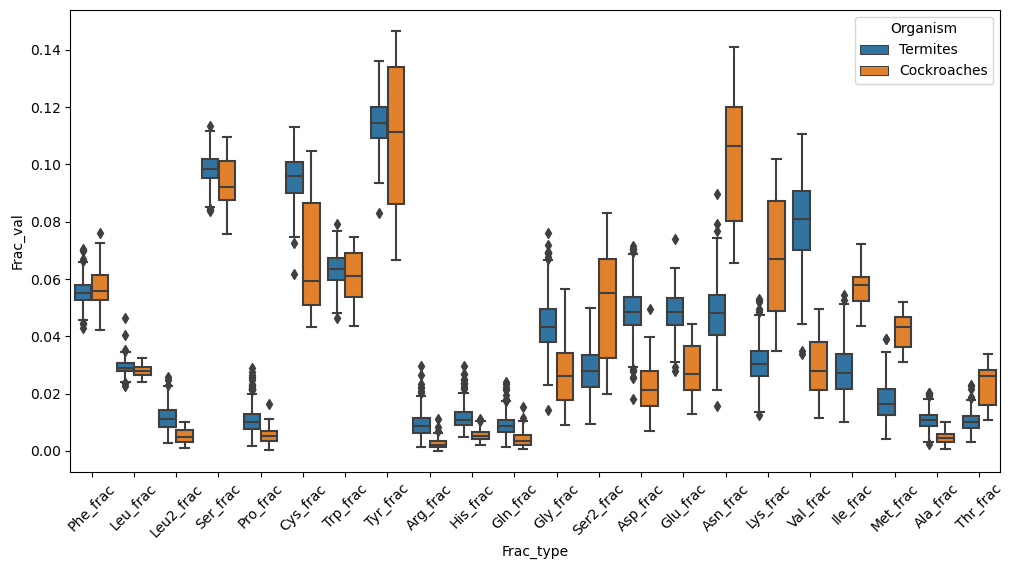

In [7]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Frac_type',
                y="Frac_val",
                hue='Organism',
                data=fracs_merged)
ax.tick_params(axis='x', labelrotation=45)

In [8]:
ag_gainers_fracs = fracs[['Species_name', 'Organism', 'Gly_frac']]
ag_losers_fracs = fracs[['Species_name', 'Organism', 'Asn_frac', 'Lys_frac']]
ag_losers_fracs['mean'] = ag_losers_fracs[['Asn_frac', 'Lys_frac']].mean(axis=1)

/tmp/ipykernel_78566/2768642320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ag_losers_fracs['mean'] = ag_losers_fracs[['Asn_frac', 'Lys_frac']].mean(axis=1)


In [15]:
ter_ag_gainers = ag_gainers_fracs[ag_gainers_fracs['Organism'] == 'Termites']
cock_ag_gainers = ag_gainers_fracs[ag_gainers_fracs['Organism'] == 'Cockroaches']

ter_ag_losers = ag_losers_fracs[ag_losers_fracs['Organism'] == 'Termites']
cock_ag_losers = ag_losers_fracs[ag_losers_fracs['Organism'] == 'Cockroaches']



In [16]:
losers_merged = pd.concat([ter_ag_losers, cock_ag_losers])

In [17]:
losers_merged

,Species_name,Organism,Asn_frac,Lys_frac,mean
0,Acanthotermes_acanthothorax_187525,Termites,0.017621,0.030837,0.024229
1,Acanthotermes_acanthothorax_187525,Termites,0.018868,0.018868,0.018868
2,Acanthotermes_acanthothorax_187525,Termites,0.036965,0.033074,0.035019
3,Acanthotermes_acanthothorax_187525,Termites,0.043290,0.004329,0.023810
4,Acanthotermes_acanthothorax_187525,Termites,0.034221,0.026616,0.030418
...,...,...,...,...,...
4385,Pseudoglomeris_magnifica_2813672,Cockroaches,0.122137,0.095420,0.108779
4386,Pseudoglomeris_magnifica_2813672,Cockroaches,0.137566,0.079365,0.108466
4388,Pseudoglomeris_magnifica_2813672,Cockroaches,0.105422,0.063253,0.084337
4389,Pseudoglomeris_magnifica_2813672,Cockroaches,0.145299,0.076923,0.111111


/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Losers')

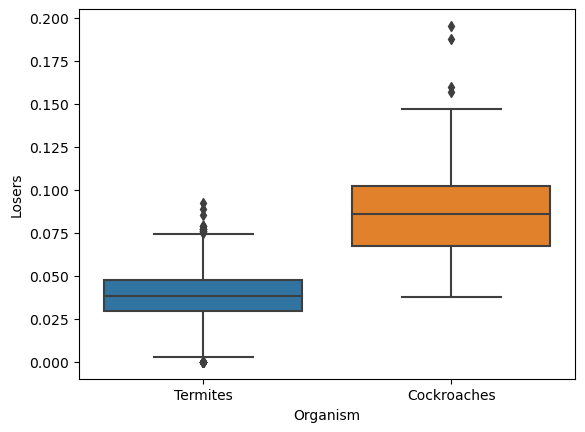

In [18]:
sns.boxplot(x='Organism',
            y='mean',
            data=losers_merged)
plt.ylabel('Losers')

In [19]:
gainers_merged = pd.concat([ter_ag_gainers, cock_ag_gainers])

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Gainers')

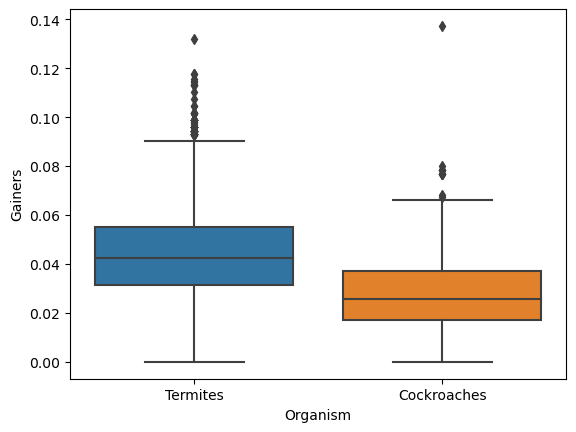

In [20]:
sns.boxplot(x='Organism',
            y='Gly_frac',
            data=gainers_merged)
plt.ylabel('Gainers')

### Negative genes


/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



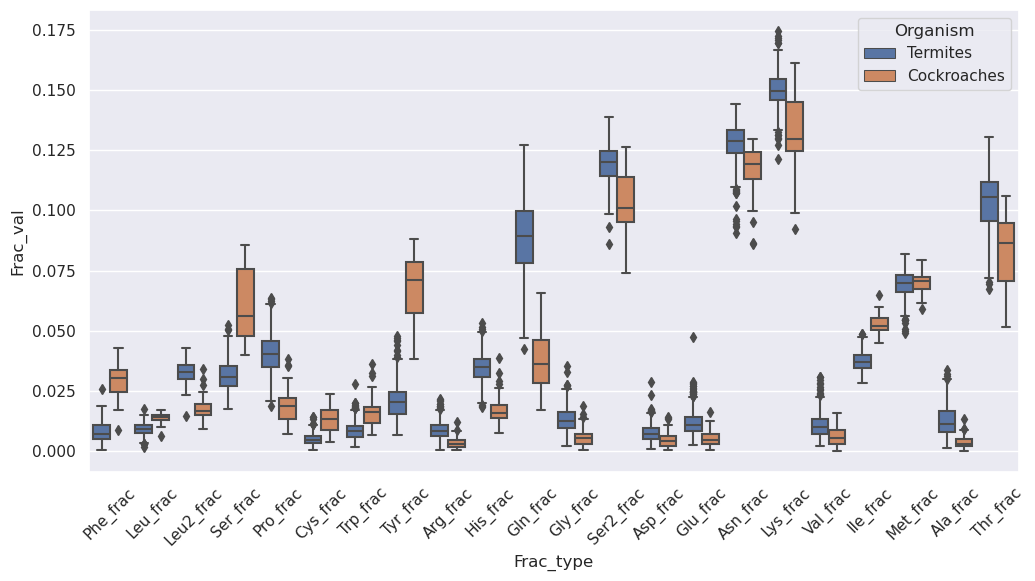

In [83]:
fracs = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/midori_Blattodea_aa_fracs.tsv', sep = '\t')
for gene in ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND2', 'ND3', 'ND6']:
    fracs = fracs.drop(fracs[fracs['Gene_name'] == gene].index)
fracs = fracs.drop(columns=['Gene_name'])
frac_types = ['Phe_frac', 'Leu_frac',
       'Leu2_frac', 'Ser_frac', 'Pro_frac', 'Cys_frac', 'Trp_frac', 'Tyr_frac',
       'Arg_frac', 'His_frac', 'Gln_frac', 'Gly_frac', 'Ser2_frac', 'Asp_frac',
       'Glu_frac', 'Asn_frac', 'Lys_frac', 'Val_frac', 'Ile_frac', 'Met_frac',
       'Ala_frac', 'Thr_frac']

ter_fracs = fracs[fracs['Organism'] == 'Termites']
cock_fracs = fracs[fracs['Organism'] == 'Cockroaches']

cock_fracs = transform_table(cock_fracs, 'Cockroaches')
term_fracs = transform_table(ter_fracs, 'Termites')

fracs_merged = pd.concat([term_fracs, cock_fracs])

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Frac_type',
                y="Frac_val",
                hue='Organism',
                data=fracs_merged)
ax.tick_params(axis='x', labelrotation=45)

### Apidae CO1 AA fracs

In [4]:
fracs = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/midori_Apidae_CO1_aa_fracs.tsv', sep = '\t')

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


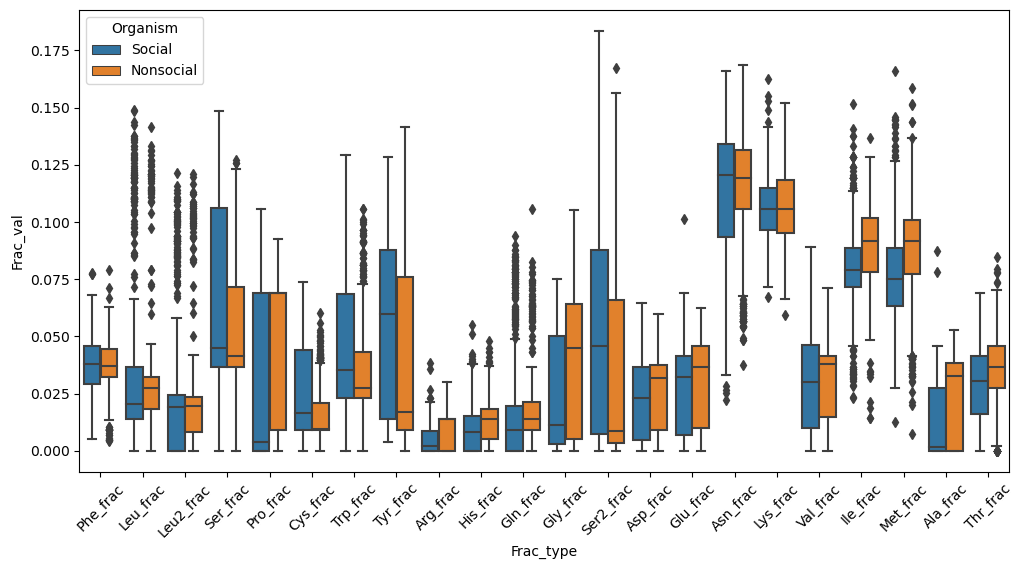

In [7]:
fracs = fracs.drop(columns=['Gene_name'])
frac_types = ['Phe_frac', 'Leu_frac',
       'Leu2_frac', 'Ser_frac', 'Pro_frac', 'Cys_frac', 'Trp_frac', 'Tyr_frac',
       'Arg_frac', 'His_frac', 'Gln_frac', 'Gly_frac', 'Ser2_frac', 'Asp_frac',
       'Glu_frac', 'Asn_frac', 'Lys_frac', 'Val_frac', 'Ile_frac', 'Met_frac',
       'Ala_frac', 'Thr_frac']

social_fracs = fracs[fracs['Organism'] == 'Social']
nonsocial_fracs = fracs[fracs['Organism'] == 'Nonsocial']

nonsocial_fracs = transform_table(nonsocial_fracs, 'Nonsocial')
social_fracs = transform_table(social_fracs, 'Social')

fracs_merged = pd.concat([social_fracs, nonsocial_fracs])

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Frac_type',
                y="Frac_val",
                hue='Organism',
                data=fracs_merged)
ax.tick_params(axis='x', labelrotation=45)

### Short tongued bees vs Long tongues bees (positive genes)

In [11]:
fracs = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/midori_Hymenoptera_aa_fracs.tsv', sep = '\t')

In [15]:
for gene in ['ND5', 'ND4', 'ND4L', 'ND1']:
    fracs = fracs.drop(fracs[fracs['Gene_name'] == gene].index)
fracs = fracs.drop(columns=['Gene_name'])
frac_types = ['Phe_frac', 'Leu_frac',
       'Leu2_frac', 'Ser_frac', 'Pro_frac', 'Cys_frac', 'Trp_frac', 'Tyr_frac',
       'Arg_frac', 'His_frac', 'Gln_frac', 'Gly_frac', 'Ser2_frac', 'Asp_frac',
       'Glu_frac', 'Asn_frac', 'Lys_frac', 'Val_frac', 'Ile_frac', 'Met_frac',
       'Ala_frac', 'Thr_frac']

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


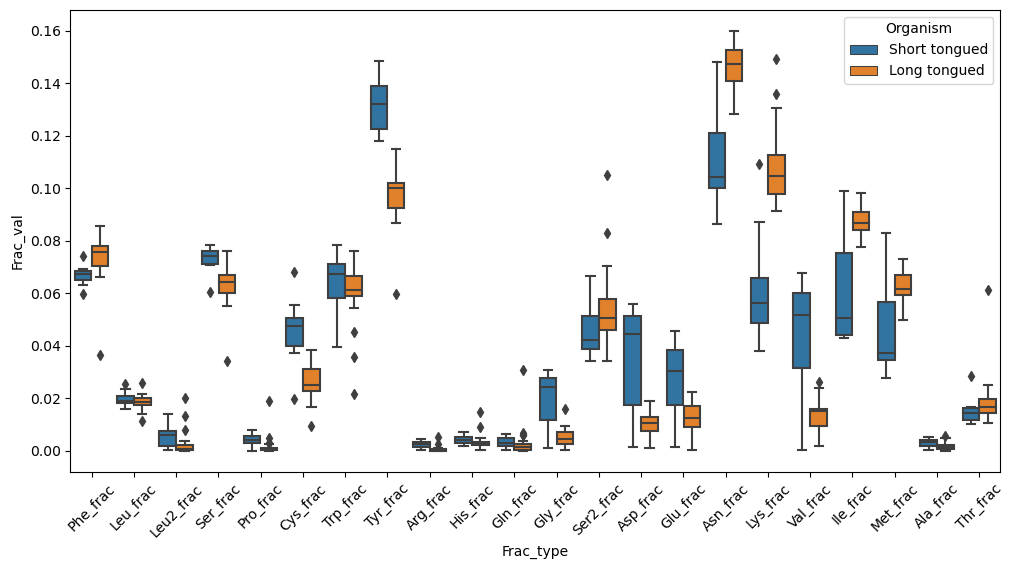

In [16]:
short_tongue_fracs = fracs[fracs['Organism'] == 'Short tongued']
long_tongue_fracs = fracs[fracs['Organism'] == 'Long tongued']

long_tongue_fracs = transform_table(long_tongue_fracs, 'Long tongued')
short_tongue_fracs = transform_table(short_tongue_fracs, 'Short tongued')

fracs_merged = pd.concat([short_tongue_fracs, long_tongue_fracs])

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Frac_type',
                y="Frac_val",
                hue='Organism',
                data=fracs_merged)
ax.tick_params(axis='x', labelrotation=45)

# Heatmap


### Positive genes


In [90]:
codon_table = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Blattodea.csv', index_col=0)

In [91]:
if REV_COMP == True:
    #reverse complementing
    codons = ['TTT', 'TTC', 'TTA', 'TTG', 'TCT', 'TCC',
           'TCA', 'TCG', 'TAT', 'TAC', 'TGT', 'TGC', 'TGG', 'CTT', 'CTC', 'CTA',
           'CTG', 'CCT', 'CCC', 'CCA', 'CCG', 'CAT', 'CAC', 'CAA', 'CAG', 'CGT',
           'CGC', 'CGA', 'CGG', 'ATT', 'ATC', 'ATA', 'ATG', 'ACT', 'ACC', 'ACA',
           'ACG', 'AAT', 'AAC', 'AAA', 'AAG', 'AGT', 'AGC', 'AGA', 'AGG', 'GTT',
           'GTC', 'GTA', 'GTG', 'GCT', 'GCC', 'GCA', 'GCG', 'GAT', 'GAC', 'GAA',
           'GAG', 'GGT', 'GGC', 'GGA', 'GGG', 'TAA', 'TAG', 'TGA']
    revcomp_codons = {}
    for cod in codons:
        revcomp = Seq(cod).reverse_complement()
        revcomp_codons[cod] = str(revcomp)
    codon_table.rename(columns=revcomp_codons, inplace=True)

In [92]:
for gene in ['ND5', 'ND4', 'ND4L', 'ND1']:
    codon_table = codon_table.drop(codon_table[codon_table['Gene_name'] == gene].index)

In [93]:
to_drop = ['Species_name','GenbankID', 'Taxonomy', 'Gene_name',
       'Gene_start_end_and_trend', 'GeneID', 'Aminoacids_from_genbank',
       'Translated_aminoacids_by_Python', 'Not_standart_codons',
       'Wrong_amino_num', 'Wrong_nucl_num', 'wrong_amino_%', 'Sequence',
       'mtDNA_length', 'nA', 'nT', 'nC', 'nG', 'nNA', '%A', '%T', '%C', '%G',
       '%NA', 'neutralA', 'neutralG', 'neutralC', 'neutralT', 'Neutral_count']
codon_table = codon_table.drop(columns=to_drop)

In [94]:
codon_table.loc[codon_table['Workers'] == 1.0, 'Workers'] = 'Termite'
codon_table.loc[codon_table['Workers'] == 0.0, 'Workers'] = 'Termite'
codon_table['Workers'] = codon_table['Workers'].fillna('Cockroach')
codon_table = codon_table.rename(columns={'Workers':'Species'})

/tmp/ipykernel_73706/2542088553.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Termite' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  codon_table.loc[codon_table['Workers'] == 1.0, 'Workers'] = 'Termite'


In [95]:
def draw_heat_map_mito(df_heatmap_codon_change_value, df_heatmap_codon_change_name,
                  df_heatmap_codon_change_aa, file_name,
                  cmd=sns.palettes.blend_palette(( '#ffffff10', '#ff0000af'), 6, as_cmap=True), 
                  title='Heatmap'):
    # cmd palette - from white to red
# Three DataFrames on import in function first - with values, second - text in heatmap cells, 
# three - amino acids that are printed on heatmap (the presence of empty cells in the data frame matters)
    fig, ax=plt.subplots(figsize=(18,18))
    # make heatmap on values and annotation is text from second DataFrame
    sns.heatmap(df_heatmap_codon_change_value, annot=df_heatmap_codon_change_name, fmt='', annot_kws={"ha":'left',"size":15}, cmap=cmd)
    # Here I add Amino acids on plot by coordiate
    for y in range(df_heatmap_codon_change_aa.shape[0]):
        for x in range(df_heatmap_codon_change_aa.shape[1]):
            plt.text(x+0.03, y+0.07, df_heatmap_codon_change_aa.iloc[y,x],horizontalalignment='left',verticalalignment='top',color='black',fontsize=25)

    # Label options
    ax.set_yticks(np.arange(0,16,1))
    ax.set_ylabel('First Nucleotide',size=20)
    ax.set_xlabel('Second Nucleotide',size=20)
    ax.set_title(title,size=20)
    ax.set_yticklabels(('', '', 'T', '', '', '', 'C', '', '', '', 'A', '', '', '', 'G', ''), 
        rotation=0, fontsize="30", va="center")
    plt.xticks(fontsize=30)
    # Here I add boxes around the amino acids the coordinates of the beginning are indicated in parentheses 
    # (0, 0) - top left
    # below is the value of the box in width (everywhere 1) and length (how many codons are included in the amino acid)
    ax.add_patch(
         patches.Rectangle(
             (0, 0),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 2),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 4),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 8),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 10),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 12),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 0),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 4),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 8),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 12),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 0),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 0),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 2),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 4),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 6),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 8),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 10),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 12),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 14),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 0),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 2),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 4),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 8),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 10),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 12),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    plt.show()
    #fig.savefig(f'{file_name}.pdf', dpi=300)

/tmp/ipykernel_73706/983253563.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table_for_heatmap = pd.concat([df, table_for_heatmap])
/tmp/ipykernel_73706/983253563.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['for_count'][i] = i
/tmp/ipykernel_73706/983253563.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['for_count'][

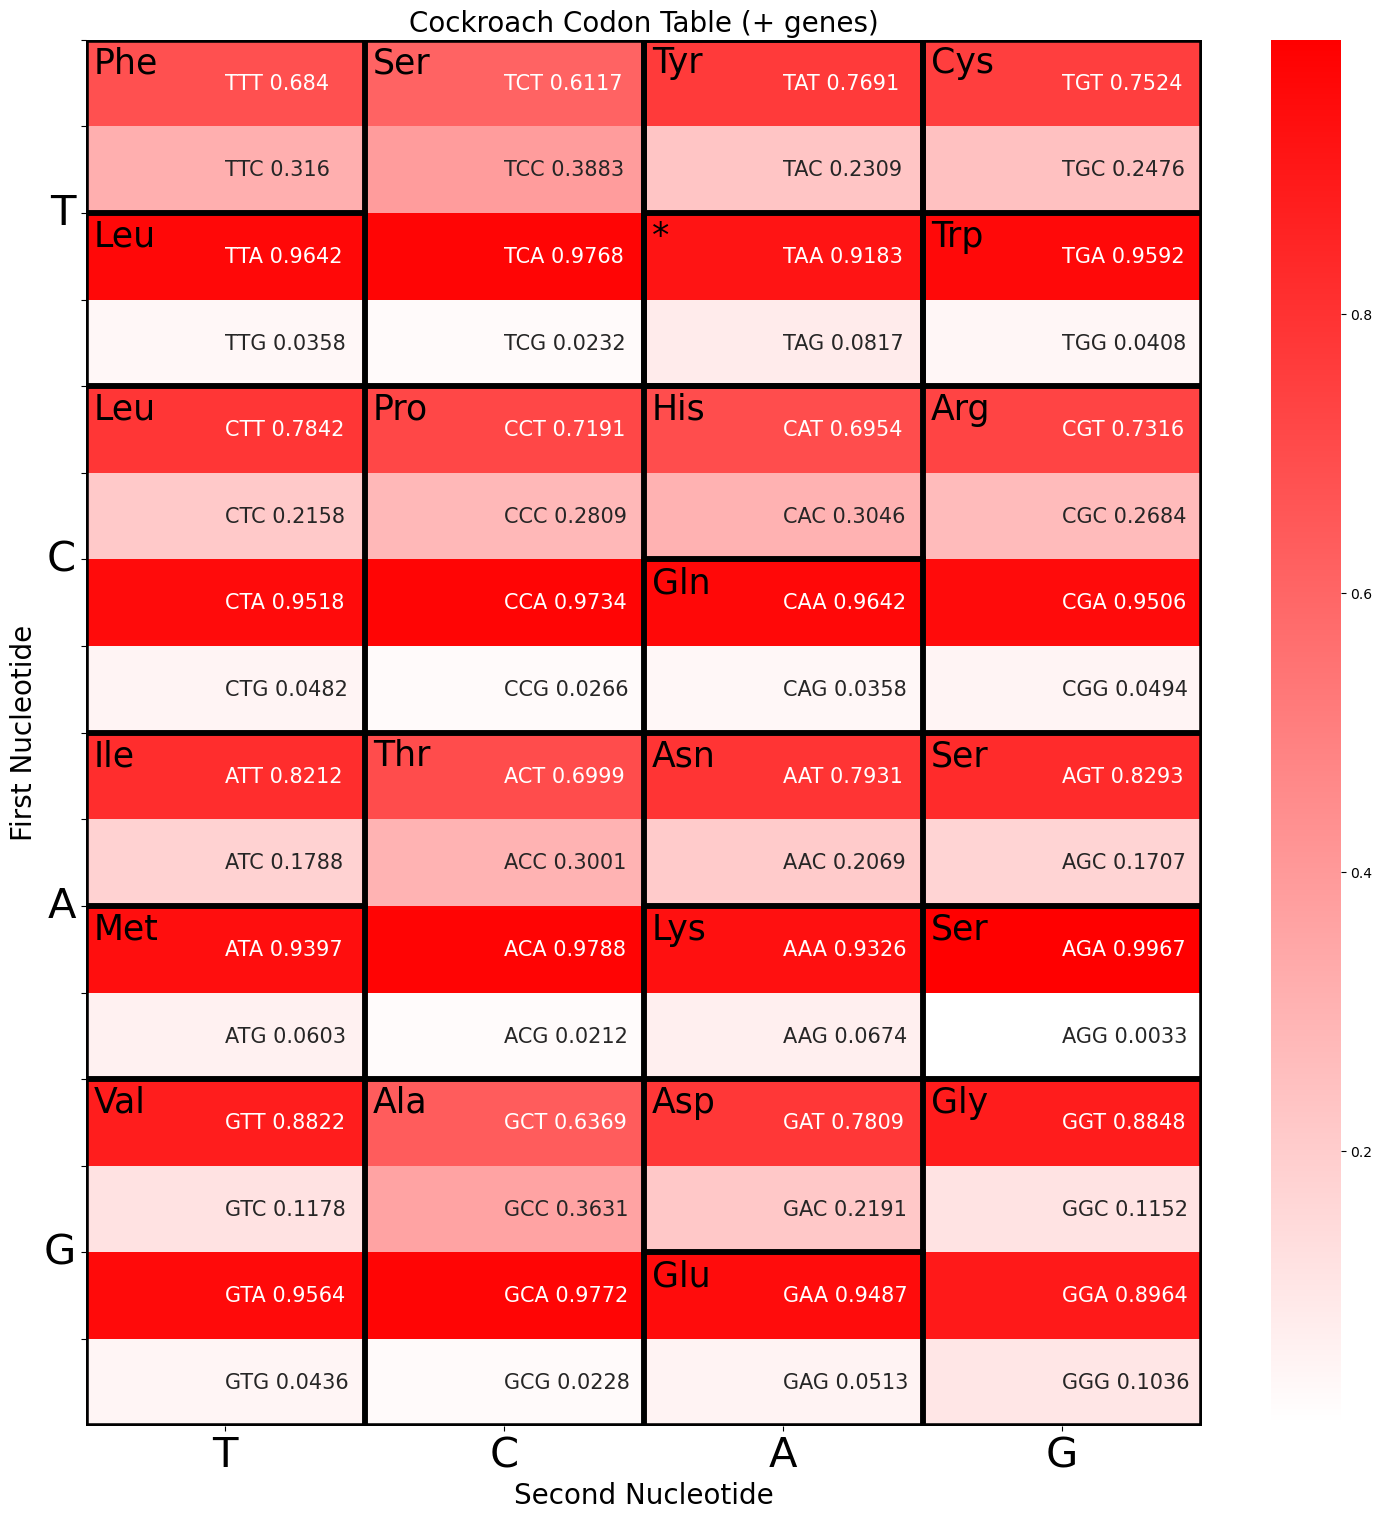

In [96]:
df = codon_table[codon_table['Species'] == 'Cockroach']
df = df.iloc[:, 1:].mean().to_frame().T
df.insert(loc=0, column="Species", value='Cockroach')

# Make list with all codons
codons_t = []
nuc_one = ['A', 'T', 'G', 'C']
nuc_two = ['A', 'T', 'G', 'C']
nuc_three = ['A', 'T', 'G', 'C']
for first in nuc_one:
    for second in nuc_two:
        for three in nuc_three:
            codons_t.append(first+second+three)

# Please, change the name of organism if it is neccessary
organism = 'Cockroach'
name = organism
#Select only organism and codons, tar_ros name comes from original selected species
df_tar_ros = df[df['Species'] == organism][codons_t].reset_index(drop=True)

table_for_heatmap = pd.DataFrame(columns=['codon', 'aa', 'codon_count'])

index_num = 0
for codon in df_tar_ros.columns:
    codon_name = codon
    # Make amino acids from codons
    aa_name = seq3(Seq(codon).translate()[0])
    value = df_tar_ros[codon].sum()
    data = {'codon':codon_name, 'aa':aa_name, 'codon_count':value}
    df = pd.DataFrame(data, index=[index_num])
    table_for_heatmap = pd.concat([df, table_for_heatmap])
    index_num+=1

#small changes to the mitochondrial code, for sure it can be done using biopython, but I'm too lazy to look
table_for_heatmap.loc[table_for_heatmap['codon'] == 'ATA','aa'] = 'Met'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'TGA','aa'] = 'Trp'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'AGA','aa'] = 'Ser'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'AGG','aa'] = 'Ser'

# for sorting by nucleotides levels - TCAG, if you change it - change everywhere in code
table_for_heatmap['first_nucl'] = table_for_heatmap['codon'].astype(str).str[0]
table_for_heatmap['second_nucl'] = table_for_heatmap['codon'].astype(str).str[1]
table_for_heatmap['three_nucl'] = table_for_heatmap['codon'].astype(str).str[2]
table_for_heatmap['first_nucl'] = pd.Categorical(table_for_heatmap['first_nucl'],categories=list('TCAG'))
table_for_heatmap['second_nucl'] = pd.Categorical(table_for_heatmap['second_nucl'],categories=list('TCAG'))
table_for_heatmap['three_nucl'] = pd.Categorical(table_for_heatmap['three_nucl'],categories=list('TCAG'))

# sorting
table_for_heatmap = table_for_heatmap.sort_values(by=['second_nucl','first_nucl','three_nucl']).reset_index(drop=True)

# this is crutch for summing codons that are located nearby, every two codons - one number and after - sum by number
table_for_heatmap['for_count'] = 0
for i in range(0,len(table_for_heatmap),2):
    table_for_heatmap['for_count'][i] = i
    table_for_heatmap['for_count'][i+1] = i

# count fractions of neighboring codons
table_for_heatmap['codon_prop'] = 0.
for index, row in table_for_heatmap.iterrows():
    if table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum() != 0:
        table_for_heatmap['codon_prop'][index] = table_for_heatmap['codon_count'][index] / table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum()

# make three different DF for heatmap
c_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'C']['codon_prop'])
u_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'T']['codon_prop'])
g_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'G']['codon_prop'])
a_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'A']['codon_prop'])
df_heatmap_codon_change_value = pd.DataFrame({'T':u_value, 'C':c_value, 'A':a_value, 'G':g_value})

name_df = table_for_heatmap[['codon', 'aa', 'codon_prop', 'second_nucl']]
name_df.loc[name_df.duplicated('aa'), 'aa'] = ''
name_df.loc[name_df['codon'] == 'CTT','aa'] = 'Leu'
name_df.loc[name_df['codon'] == 'AGT','aa'] = 'Ser'
name_df.loc[name_df['codon'] == 'AGA','aa'] = 'Ser'
name_df.loc[name_df['codon'] == 'TAA','aa'] = '*'
name_df['codon_prop'] = round(name_df['codon_prop'],4).astype('str')
name_df['summ_info'] = name_df['codon'] + ' ' + name_df['codon_prop']
c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
u_name = list(name_df[name_df['second_nucl'] == 'T']['summ_info'])
g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
df_heatmap_codon_change_name = pd.DataFrame({'T':u_name, 'C':c_name, 'A':a_name, 'G':g_name})

c_aa = list(name_df[name_df['second_nucl'] == 'C']['aa'])
u_aa = list(name_df[name_df['second_nucl'] == 'T']['aa'])
g_aa = list(name_df[name_df['second_nucl'] == 'G']['aa'])
a_aa = list(name_df[name_df['second_nucl'] == 'A']['aa'])
df_heatmap_codon_change_aa = pd.DataFrame({'T':u_aa, 'C':c_aa, 'A':a_aa, 'G':g_aa})

cock_table_for_heatmap = table_for_heatmap

#call function for drawing
draw_heat_map_mito(df_heatmap_codon_change_value, df_heatmap_codon_change_name, 
              df_heatmap_codon_change_aa, f'{name}', title=f'{name} Codon Table (+ genes)')

/tmp/ipykernel_73706/3825194093.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table_for_heatmap = pd.concat([df, table_for_heatmap])
/tmp/ipykernel_73706/3825194093.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['for_count'][i] = i
/tmp/ipykernel_73706/3825194093.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['for_count

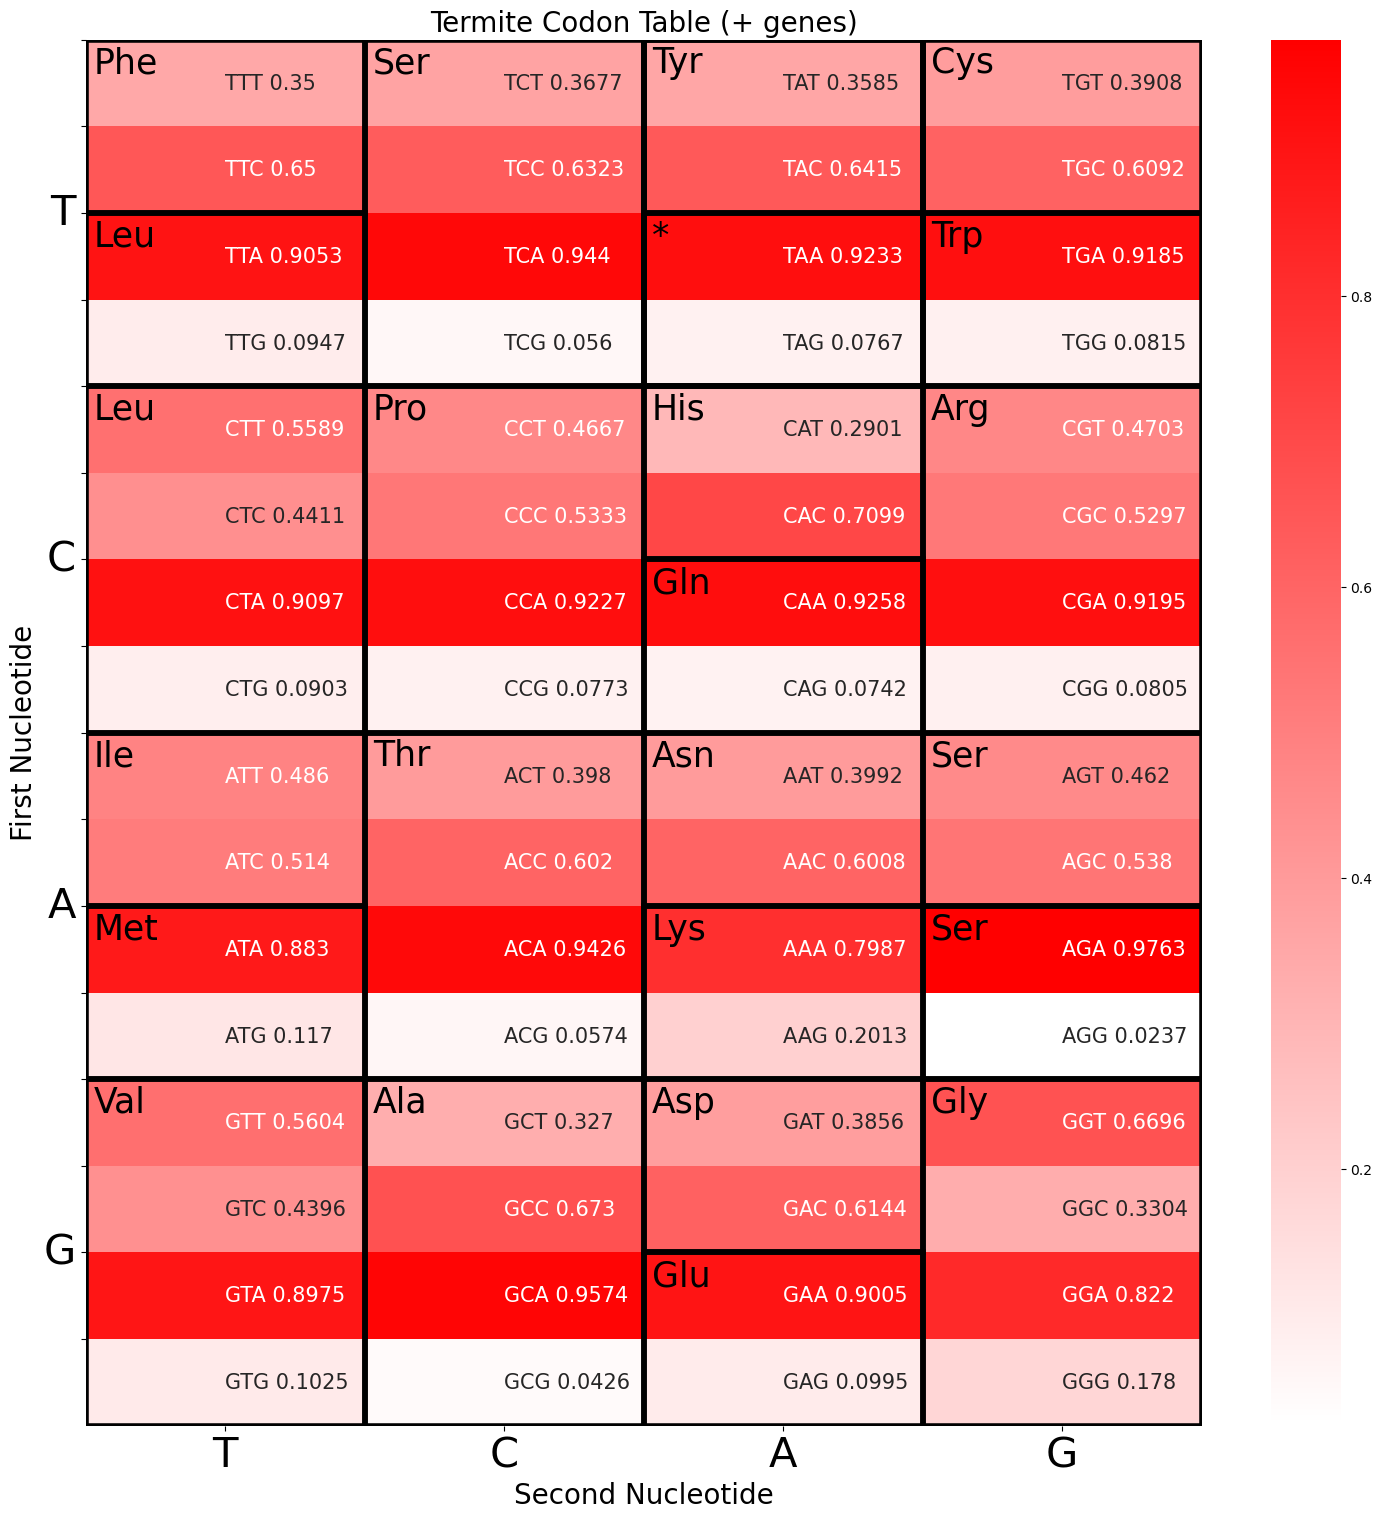

In [97]:
df = codon_table[codon_table['Species'] == 'Termite']
df = df.iloc[:, 1:].mean().to_frame().T
df.insert(loc=0, column="Species", value='Termite')

# Make list with all codons
codons_t = []
nuc_one = ['A', 'T', 'G', 'C']
nuc_two = ['A', 'T', 'G', 'C']
nuc_three = ['A', 'T', 'G', 'C']
for first in nuc_one:
    for second in nuc_two:
        for three in nuc_three:
            codons_t.append(first+second+three)

# Please, change the name of organism if it is neccessary
organism = 'Termite'
name = organism
#Select only organism and codons, tar_ros name comes from original selected species
df_tar_ros = df[df['Species'] == organism][codons_t].reset_index(drop=True)

table_for_heatmap = pd.DataFrame(columns=['codon', 'aa', 'codon_count'])

index_num = 0
for codon in df_tar_ros.columns:
    codon_name = codon
    # Make amino acids from codons
    aa_name = seq3(Seq(codon).translate()[0])
    value = df_tar_ros[codon].sum()
    data = {'codon':codon_name, 'aa':aa_name, 'codon_count':value}
    df = pd.DataFrame(data, index=[index_num])
    table_for_heatmap = pd.concat([df, table_for_heatmap])
    index_num+=1

#small changes to the mitochondrial code, for sure it can be done using biopython, but I'm too lazy to look
table_for_heatmap.loc[table_for_heatmap['codon'] == 'ATA','aa'] = 'Met'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'TGA','aa'] = 'Trp'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'AGA','aa'] = 'Ser'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'AGG','aa'] = 'Ser'

# for sorting by nucleotides levels - TCAG, if you change it - change everywhere in code
table_for_heatmap['first_nucl'] = table_for_heatmap['codon'].astype(str).str[0]
table_for_heatmap['second_nucl'] = table_for_heatmap['codon'].astype(str).str[1]
table_for_heatmap['three_nucl'] = table_for_heatmap['codon'].astype(str).str[2]
table_for_heatmap['first_nucl'] = pd.Categorical(table_for_heatmap['first_nucl'],categories=list('TCAG'))
table_for_heatmap['second_nucl'] = pd.Categorical(table_for_heatmap['second_nucl'],categories=list('TCAG'))
table_for_heatmap['three_nucl'] = pd.Categorical(table_for_heatmap['three_nucl'],categories=list('TCAG'))

# sorting
table_for_heatmap = table_for_heatmap.sort_values(by=['second_nucl','first_nucl','three_nucl']).reset_index(drop=True)

# this is crutch for summing codons that are located nearby, every two codons - one number and after - sum by number
table_for_heatmap['for_count'] = 0
for i in range(0,len(table_for_heatmap),2):
    table_for_heatmap['for_count'][i] = i
    table_for_heatmap['for_count'][i+1] = i

# count fractions of neighboring codons
table_for_heatmap['codon_prop'] = 0.
for index, row in table_for_heatmap.iterrows():
    if table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum() != 0:
        table_for_heatmap['codon_prop'][index] = table_for_heatmap['codon_count'][index] / table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum()

# make three different DF for heatmap
c_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'C']['codon_prop'])
u_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'T']['codon_prop'])
g_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'G']['codon_prop'])
a_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'A']['codon_prop'])
df_heatmap_codon_change_value = pd.DataFrame({'T':u_value, 'C':c_value, 'A':a_value, 'G':g_value})

name_df = table_for_heatmap[['codon', 'aa', 'codon_prop', 'second_nucl']]
name_df.loc[name_df.duplicated('aa'), 'aa'] = ''
name_df.loc[name_df['codon'] == 'CTT','aa'] = 'Leu'
name_df.loc[name_df['codon'] == 'AGT','aa'] = 'Ser'
name_df.loc[name_df['codon'] == 'AGA','aa'] = 'Ser'
name_df.loc[name_df['codon'] == 'TAA','aa'] = '*'
name_df['codon_prop'] = round(name_df['codon_prop'],4).astype('str')
name_df['summ_info'] = name_df['codon'] + ' ' + name_df['codon_prop']
c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
u_name = list(name_df[name_df['second_nucl'] == 'T']['summ_info'])
g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
df_heatmap_codon_change_name = pd.DataFrame({'T':u_name, 'C':c_name, 'A':a_name, 'G':g_name})

c_aa = list(name_df[name_df['second_nucl'] == 'C']['aa'])
u_aa = list(name_df[name_df['second_nucl'] == 'T']['aa'])
g_aa = list(name_df[name_df['second_nucl'] == 'G']['aa'])
a_aa = list(name_df[name_df['second_nucl'] == 'A']['aa'])
df_heatmap_codon_change_aa = pd.DataFrame({'T':u_aa, 'C':c_aa, 'A':a_aa, 'G':g_aa})

ter_table_for_heatmap = table_for_heatmap

#call function for drawing
draw_heat_map_mito(df_heatmap_codon_change_value, df_heatmap_codon_change_name, 
              df_heatmap_codon_change_aa, f'{name}', title=f'{name} Codon Table (+ genes)')

In [85]:
ter_table_for_heatmap

,codon,aa,codon_count,first_nucl,second_nucl,three_nucl,for_count,codon_prop
0,TTT,Phe,5.788184,T,T,T,0,0.489955
1,TTC,Phe,6.025512,T,T,C,0,0.510045
2,TTA,Leu,0.832494,T,T,A,2,0.132295
3,TTG,Leu,5.460222,T,T,G,2,0.867705
4,CTT,Leu,1.458879,C,T,T,4,0.686680
...,...,...,...,...,...,...,...,...
59,AGG,Ser,1.743874,A,G,G,58,0.602948
60,GGT,Gly,4.372273,G,G,T,60,0.573283
61,GGC,Gly,3.254448,G,G,C,60,0.426717
62,GGA,Gly,1.974488,G,G,A,62,0.497673


In [86]:
cock_table_for_heatmap

,codon,aa,codon_count,first_nucl,second_nucl,three_nucl,for_count,codon_prop
0,TTT,Phe,6.360269,T,T,T,0,0.533014
1,TTC,Phe,5.572391,T,T,C,0,0.466986
2,TTA,Leu,0.776094,T,T,A,2,0.117963
3,TTG,Leu,5.803030,T,T,G,2,0.882037
4,CTT,Leu,0.459596,C,T,T,4,0.603982
...,...,...,...,...,...,...,...,...
59,AGG,Ser,3.848485,A,G,G,58,0.592075
60,GGT,Gly,1.878788,G,G,T,60,0.492281
61,GGC,Gly,1.937710,G,G,C,60,0.507719
62,GGA,Gly,1.683502,G,G,A,62,0.528262


In [88]:
mannwhitneyu(ter_table_for_heatmap['codon_count'], cock_table_for_heatmap['codon_count'])

MannwhitneyuResult(statistic=2201.0, pvalue=0.46737850546823867)

# All Insecta A>G vs Gainer/Loser scatter plot

In [14]:
#mutspec related data
# Swap that to True if you want to invert nucls
INVERT = True
#Change to true to filter mutspecs by num of total muts and num of mut types
FILTER = True
PATH_TO_12MUTSPEC = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/ms12syn_internal_iqtree.tsv'
PATH_TO_METADATA = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/AllInsects/midori_all_insects_mutspec/msMetaData.tsv'
PATH_TO_STRAND_CHECK = '/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/insectsGB_with_diff_strand_loc.tsv'

mutspec12 = pd.read_csv(PATH_TO_12MUTSPEC, sep='\t')

if INVERT == True:
    # inverts nucls for ms12, needs to be run only once. DO NOT FUCKING DO IT! Now we stick to original mutspec (with higher T>C rather than A>G)
    a_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'A>G'], mutspec12[mutspec12['Mut'] == 'A>C'], mutspec12[mutspec12['Mut'] == 'A>T']])
    t_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'T>G'], mutspec12[mutspec12['Mut'] == 'T>C'], mutspec12[mutspec12['Mut'] == 'T>A']])
    g_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'G>T'], mutspec12[mutspec12['Mut'] == 'G>C'], mutspec12[mutspec12['Mut'] == 'G>A']])
    c_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'C>T'], mutspec12[mutspec12['Mut'] == 'C>G'], mutspec12[mutspec12['Mut'] == 'C>A']])

    a_spec.loc[a_spec['Mut'] == 'A>G', 'Mut'] = 'T>C'
    a_spec.loc[a_spec['Mut'] == 'A>C', 'Mut'] = 'T>G'
    a_spec.loc[a_spec['Mut'] == 'A>T', 'Mut'] = 'T>A'

    t_spec.loc[t_spec['Mut'] == 'T>G', 'Mut'] = 'A>C'
    t_spec.loc[t_spec['Mut'] == 'T>C', 'Mut'] = 'A>G'
    t_spec.loc[t_spec['Mut'] == 'T>A', 'Mut'] = 'A>T'

    g_spec.loc[g_spec['Mut'] == 'G>T', 'Mut'] = 'C>A'
    g_spec.loc[g_spec['Mut'] == 'G>C', 'Mut'] = 'C>G'
    g_spec.loc[g_spec['Mut'] == 'G>A', 'Mut'] = 'C>T'

    c_spec.loc[c_spec['Mut'] == 'C>T', 'Mut'] = 'G>A'
    c_spec.loc[c_spec['Mut'] == 'C>G', 'Mut'] = 'G>C'
    c_spec.loc[c_spec['Mut'] == 'C>A', 'Mut'] = 'G>T'

    mutspec12 = pd.concat([a_spec, t_spec, g_spec, c_spec]).sort_values(by=['Species', 'Mut'])

mutspec12 = mutspec12.sort_values(['Species', 'Mut'])
meta_df = pd.read_csv(PATH_TO_METADATA, sep='\t').sort_values(by='Species')


def chop(l, chunk_size):
    for i in range(0, len(l), chunk_size):
        yield l[i:i + chunk_size]

if FILTER == True:
    #removing species with less than 15 total mutations - might need to bump up for all insects (do not do it for termites)
    mut_ammount_df = mutspec12.groupby(mutspec12['Species']).aggregate({'ObsNum' : 'sum'}).reset_index()
    less_than_15_total_muts = mut_ammount_df.drop(mut_ammount_df[mut_ammount_df['ObsNum'] > 15].index)['Species'].to_list()
    for sp in less_than_15_total_muts:
        mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
        meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)
    
    #removing species with less than 4 mutation types - might need to bump up for all insects (do not do it for termites)
    species = mutspec12['Species'].drop_duplicates().to_list()
    obsnum_values = mutspec12['ObsNum'].to_list()
    chopped_obsnum =  list(chop(obsnum_values, 12))
    
    species_and_obsnum = {}
    for i in range(len(species)):
        species_and_obsnum[species[i]] = chopped_obsnum[i]
    
    less_than_4_mut_types = []
    for sp, obsnum_list in species_and_obsnum.items():
        if obsnum_list.count(0) > 8: # 8 for less than 4 mut types, 4 is less than 8 mut types, 2 is less than 10 mut types, 0 for less than 12 mut type, i.e. all mut types are present
            less_than_4_mut_types.append(sp)
    
    for sp in less_than_4_mut_types:
        mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
        meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)

mutspec12 = mutspec12.fillna(0)

strand_check = pd.read_csv(PATH_TO_STRAND_CHECK, sep='\t', index_col=0)
def format_sp(sp):
    return re.sub('\s','_',sp)
strand_check['species'] = strand_check['species'].apply(format_sp)
for sp in strand_check['species']:
    meta_df = meta_df.drop(meta_df.iloc[meta_df.index == sp].index)
#drop all mut types but A>G
mutspec12 = mutspec12[mutspec12['Mut'] == 'A>G']

In [15]:
fracs = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/midori_Insecta_CO1_aa_fracs.tsv', sep = '\t')

In [16]:
#drop all genes but CO1
fracs = fracs[fracs['Gene_name'] == 'CO1']
fracs = fracs.drop(columns=['Gene_name']).reset_index(drop=True)

In [17]:
#Set to true, to use all gainers and losers from codontable, false to use only A>G driven
ALL_AMINO = False
if ALL_AMINO:
    fracs['Gainer/Loser'] = (fracs['Phe_frac'] + fracs['Leu_frac'] + fracs['Cys_frac'] + fracs['Trp_frac'] + fracs['Ser2_frac'] + fracs['Gly_frac'] + fracs['Val_frac'])/(fracs['Pro_frac'] + fracs['Thr_frac'] + fracs['Asn_frac'] + fracs['Lys_frac'] + fracs['His_frac'] + fracs['Gln_frac'])
else:
    fracs['Gainer/Loser'] = (fracs['Gly_frac'])/(fracs['Asn_frac'] + fracs['Lys_frac'])

In [18]:
def format_sp(sp):
    return re.sub('_[0-9]*$','',sp)
fracs['Species_name'] = fracs['Species_name'].apply(format_sp)

In [19]:
fracs

,Species_name,Organism,Phe_frac,Leu_frac,Leu2_frac,Ser_frac,Pro_frac,Cys_frac,Trp_frac,Tyr_frac,...,Asp_frac,Glu_frac,Asn_frac,Lys_frac,Val_frac,Ile_frac,Met_frac,Ala_frac,Thr_frac,Gainer/Loser
0,Aaaba_fossicollis,NaN,0.021951,0.012195,0.007317,0.100000,0.034146,0.039024,0.039024,0.087805,...,0.024390,0.026829,0.092683,0.078049,0.058537,0.036585,0.026829,0.009756,0.024390,0.385714
1,Aacanthocnema_dobsoni,NaN,0.031434,0.017682,0.000000,0.100196,0.011788,0.035363,0.049116,0.080550,...,0.011788,0.021611,0.129666,0.082515,0.035363,0.049116,0.049116,0.005894,0.033399,0.064815
2,Aagaardia_protensa,NaN,0.032110,0.013761,0.013761,0.045872,0.105505,0.009174,0.022936,0.004587,...,0.036697,0.036697,0.032110,0.133028,0.059633,0.091743,0.055046,0.073394,0.068807,0.333333
3,Aaroniella_badonneli,NaN,0.022936,0.022936,0.036697,0.045872,0.087156,0.013761,0.022936,0.004587,...,0.032110,0.018349,0.077982,0.096330,0.059633,0.073394,0.087156,0.068807,0.050459,0.368421
4,Abablemma_bilineata,NaN,0.022936,0.032110,0.032110,0.045872,0.096330,0.009174,0.022936,0.004587,...,0.013761,0.041284,0.050459,0.114679,0.050459,0.077982,0.096330,0.077982,0.036697,0.361111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122876,Zythos_strigata,NaN,0.027523,0.036697,0.022936,0.041284,0.100917,0.009174,0.022936,0.013761,...,0.013761,0.041284,0.073394,0.114679,0.055046,0.073394,0.096330,0.073394,0.045872,0.317073
122877,Zythos_turbata,NaN,0.032110,0.032110,0.022936,0.041284,0.100917,0.009174,0.022936,0.013761,...,0.027523,0.027523,0.091743,0.100917,0.055046,0.059633,0.110092,0.073394,0.045872,0.309524
122878,Zyxomma_obtusum,NaN,0.020134,0.033557,0.033557,0.046980,0.087248,0.013423,0.006711,0.006711,...,0.033557,0.013423,0.114094,0.067114,0.067114,0.080537,0.040268,0.107383,0.073826,0.444444
122879,Zyxomma_petiolatum,NaN,0.048889,0.106667,0.195556,0.000000,0.022222,0.004444,0.017778,0.048889,...,0.031111,0.026667,0.035556,0.044444,0.071111,0.040000,0.102222,0.000000,0.000000,0.166667


In [20]:
filter_sp = []
for sp in tqdm(fracs['Species_name'], total=len(fracs['Species_name'])):
    filter_sp.append(mutspec12[mutspec12['Species'] == sp])
mutspec12 = pd.concat(filter_sp)
mutspec12.sort_values(by=['Species'], inplace=True)
mutspec12.reset_index(drop=True, inplace=True)

filter_sp = []
for sp in tqdm(mutspec12['Species'], total=len(mutspec12['Species'])):
    filter_sp.append(meta_df[meta_df['Species'] == sp])
meta_df = pd.concat(filter_sp)
meta_df.sort_values(by=['Species'], inplace=True)
meta_df.reset_index(drop=True, inplace=True)

filter_sp = []
for sp in tqdm(mutspec12['Species'], total=len(mutspec12['Species'])):
    filter_sp.append(fracs[fracs['Species_name'] == sp])
fracs = pd.concat(filter_sp)
fracs.sort_values(by=['Species_name'], inplace=True)
fracs.reset_index(drop=True, inplace=True)
fracs['A>G'] = mutspec12['MutSpec']
fracs['Order'] = meta_df['Order']
fracs['Family'] = meta_df['Family']
fracs = fracs[['Species_name', 'Order', 'Family', 'Gainer/Loser', 'A>G']]

100%|██████████| 5490/5490 [00:19<00:00, 276.76it/s]


/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/tmp/ipyke

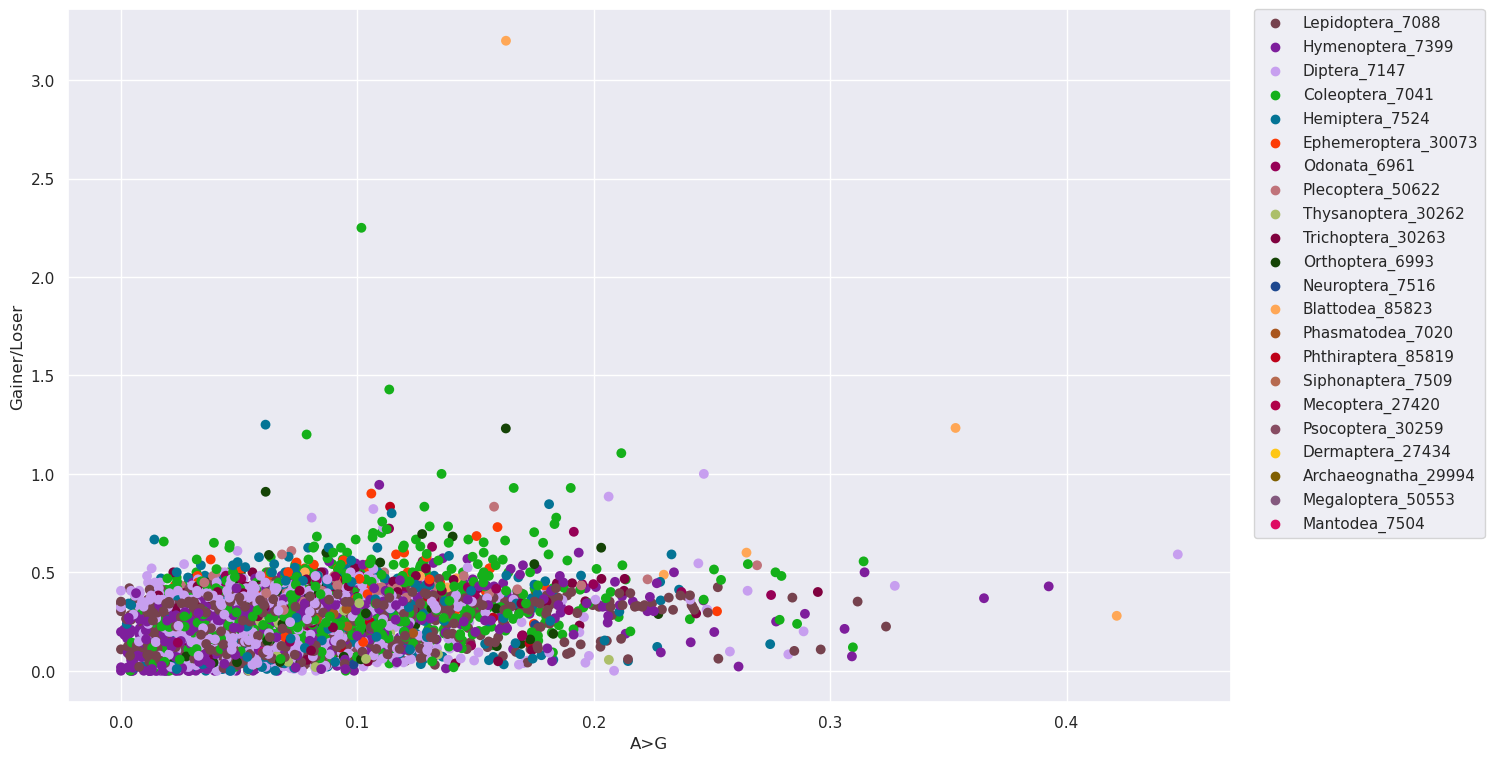

In [98]:
#shitty palette, if you have 20 orders, then use tab20 palette
if len(fracs['Order'].unique()) > 20:
    palette = sns.xkcd_palette(['brownish purple', 'purple', 'lavender', 'green', 'sea blue', 'red orange', 'dark magenta', 'dusty rose',
                      'light olive', 'wine', 'forrest green', 'cobalt', 'pale orange', 'sienna', 'scarlet', 'clay', 'raspberry', 'dark mauve',
                      'golden yellow', 'poop', 'dull purple', 'cerise', 'coffee'])
else:
    palette = 'tab20'
sns.set_theme(rc={"figure.figsize":(15, 9)})
sns.scatterplot(fracs, x='A>G', y='Gainer/Loser', hue='Order', palette=palette, linewidth = 0, s=50)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [11]:
len(fracs['Order'].unique())

22

In [41]:
fracs

,Species_name,Order,Family,Gainer/Loser,A>G
0,Abagrotis_variata,Lepidoptera_7088,Noctuidae_7100,0.317073,0.068500
1,Abantiades_argentata,Lepidoptera_7088,Hepialidae_41021,0.282609,0.020485
2,Abantiades_atripalpis,Lepidoptera_7088,Hepialidae_41021,0.282609,0.026273
3,Abantiades_obscura,Lepidoptera_7088,Hepialidae_41021,0.276596,0.086887
4,Abia_aenea,Hymenoptera_7399,Cimbicidae_85775,0.268293,0.025614
...,...,...,...,...,...
5485,Zygaena_romeo,Lepidoptera_7088,Zygaenidae_115354,0.358974,0.058877
5486,Zygaena_transalpina,Lepidoptera_7088,Zygaenidae_115354,0.341463,0.020637
5487,Zygaena_viciae,Lepidoptera_7088,Zygaenidae_115354,0.333333,0.060541
5488,Zygaenoprocris_chalcochlora,Lepidoptera_7088,Zygaenidae_115354,0.400000,0.123283


In [42]:
fig = px.scatter(fracs, x='A>G', y='Gainer/Loser', color='Order', marginal_x='histogram', marginal_y='histogram', color_discrete_sequence=px.colors.qualitative.Light24, hover_data=['Species_name'], title='Correlation of Gainer to Loser ratio and A>G of CO1 of 5490 species')
fig.update_layout(width=1440,
    height=1024,
    )
fig.show()

In [44]:
fig.write_html('/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/GLratio_A>G_corr.html')

In [51]:
rho, p = spearmanr(fracs['Gainer/Loser'], fracs['A>G'])
print(f'Insecta spearman:\nRho --- {rho}\np-value --- {p}')

Insecta spearman:
Rho --- 0.2794220224465908
p-value --- 5.100039371864527e-99


In [76]:
orders = fracs['Order'].unique()
for order in orders:
    check = '(x)'
    tmp_df = fracs[fracs['Order'] == order]
    if len(tmp_df) > 2:
        rho, p = spearmanr(tmp_df['Gainer/Loser'], tmp_df['A>G'])
        if p < 0.05:
            check = '(< 0.05)'
        print(f'{order} spearman:\nRho --- {rho}\np-value --- {p} {check}\n' + '='*42)
    else:
        print(f'Too few species species in {order}\n' +'='*42)

Lepidoptera_7088 spearman:
Rho --- 0.1740672763997924
p-value --- 4.985615324121539e-11 (< 0.05)
Hymenoptera_7399 spearman:
Rho --- 0.4308318392222229
p-value --- 3.1924603860192125e-37 (< 0.05)
Diptera_7147 spearman:
Rho --- 0.15777928483355858
p-value --- 1.6001541986560214e-08 (< 0.05)
Coleoptera_7041 spearman:
Rho --- 0.3803282840099862
p-value --- 1.1798223923521189e-36 (< 0.05)
Hemiptera_7524 spearman:
Rho --- 0.24984006403230458
p-value --- 3.6681102452838427e-06 (< 0.05)
Ephemeroptera_30073 spearman:
Rho --- 0.11365084951422849
p-value --- 0.2626780974761088 (x)
Odonata_6961 spearman:
Rho --- 0.38546989980700325
p-value --- 0.0006949492805958634 (< 0.05)
Plecoptera_50622 spearman:
Rho --- 0.12883537261691194
p-value --- 0.2914068271520339 (x)
Thysanoptera_30262 spearman:
Rho --- 0.09994353472614344
p-value --- 0.6581099564182369 (x)
Trichoptera_30263 spearman:
Rho --- 0.20744660690701652
p-value --- 0.0020286805116870306 (< 0.05)
Orthoptera_6993 spearman:
Rho --- 0.210350466012

In [75]:
len(orders)

22

# Orthoptera Gainer/loser vs egg clutch size

In [51]:
orthoptera_traits = pd.read_csv('/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/EcoMorphDBs/orthoptera_lifetraits.tsv', sep='\t')
orthoptera_traits = orthoptera_traits[['Species','Length', 'Clutch_S']].dropna()

In [52]:
codon_table = pd.read_csv('/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/codontable_midori_Orthoptera_CO1.csv')

In [53]:
def format_sp(sp):
    return re.sub('_*[0-9]','',sp)
codon_table['Species_name'] = codon_table['Species_name'].apply(format_sp)

In [54]:
tmp = []
for sp in orthoptera_traits['Species']:
    tmp.append(codon_table.loc[codon_table['Species_name'] == sp])
codon_table = pd.concat(tmp)

In [55]:
fracs = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/DescriptiveStat/midori_Orthoptera_CO1_aa_fracs.tsv', sep = '\t')
fracs['Species_name'] = fracs['Species_name'].apply(format_sp)

In [56]:
tmp = []
for sp in orthoptera_traits['Species']:
    tmp.append(fracs.loc[fracs['Species_name'] == sp])
fracs = pd.concat(tmp)

tmp = []
for sp in fracs['Species_name']:
    tmp.append(orthoptera_traits.loc[orthoptera_traits['Species'] == sp])
orthoptera_traits = pd.concat(tmp)

/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


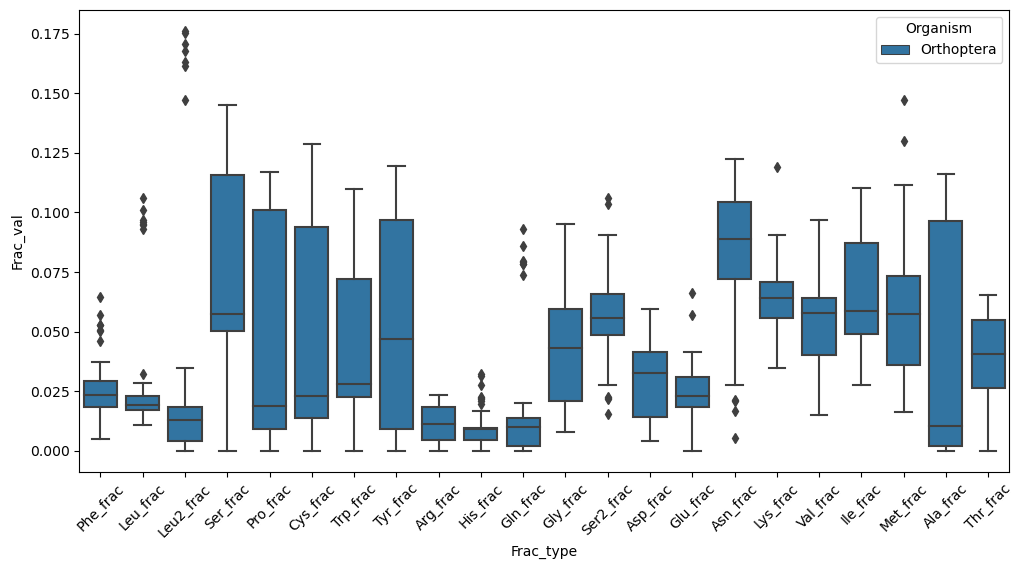

In [59]:
frac_types = ['Phe_frac', 'Leu_frac',
       'Leu2_frac', 'Ser_frac', 'Pro_frac', 'Cys_frac', 'Trp_frac', 'Tyr_frac',
       'Arg_frac', 'His_frac', 'Gln_frac', 'Gly_frac', 'Ser2_frac', 'Asp_frac',
       'Glu_frac', 'Asn_frac', 'Lys_frac', 'Val_frac', 'Ile_frac', 'Met_frac',
       'Ala_frac', 'Thr_frac']
frac_vals = transform_table(fracs.drop(columns=['Gene_name']), 'Orthoptera')
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Frac_type',
                y="Frac_val",
                hue='Organism',
                data=frac_vals)
ax.tick_params(axis='x', labelrotation=45)

In [60]:
#Set to true, to use all gainers and losers from codontable, false to use only A>G driven
ALL_AMINO = True
if ALL_AMINO:
    fracs['Gainer/Loser'] = (fracs['Phe_frac'] + fracs['Leu_frac'] + fracs['Cys_frac'] + fracs['Trp_frac'] + fracs['Ser2_frac'] + fracs['Gly_frac'] + fracs['Val_frac'])/(fracs['Pro_frac'] + fracs['Thr_frac'] + fracs['Asn_frac'] + fracs['Lys_frac'] + fracs['His_frac'] + fracs['Gln_frac'])
else:
    fracs['Gainer/Loser'] = (fracs['Gly_frac'])/(fracs['Asn_frac'] + fracs['Lys_frac'])

In [61]:
orthoptera_traits.sort_values(by=['Species'], inplace=True)
fracs.sort_values(by=['Species_name'], inplace=True)
codon_table.sort_values(by=['Species_name'], inplace=True)
orthoptera_traits.reset_index(inplace=True, drop=True)
fracs.reset_index(inplace=True, drop=True)
codon_table.reset_index(inplace=True, drop=True)

In [62]:
fracs['Length'] = orthoptera_traits['Length']
fracs['Clutch_S'] = orthoptera_traits['Clutch_S']
fracs['Taxonomy'] = codon_table['Taxonomy']

In [64]:
fracs = fracs[['Species_name', 'Gainer/Loser', 'Length', 'Clutch_S', 'Taxonomy']]

In [65]:
def format_taxonomy(tax):
    return tax.split(',')[-1][2:len(tax.split(',')[-1])-2]
fracs['Taxonomy'] = fracs['Taxonomy'].apply(format_taxonomy)

/tmp/ipykernel_31567/10487221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fracs['Taxonomy'] = fracs['Taxonomy'].apply(format_taxonomy)


In [66]:
fracs

,Species_name,Gainer/Loser,Length,Clutch_S,Taxonomy
0,Acanthacris_ruficornis,1.448276,62.3500,151.0,Acrididae_7002
1,Acheta_domesticus,1.727273,18.0000,28.2,Gryllidae_6995
2,Acrida_bicolor,1.381818,55.2000,59.5,Acrididae_7002
3,Acrolophitus_hirtipes,1.636364,37.5000,11.0,Acrididae_7002
4,Aeoloplides_turnbulli,0.939394,20.5750,18.5,Acrididae_7002
...,...,...,...,...,...
95,Trimerotropis_pallidipennis,1.683168,26.1250,37.0,Acrididae_7002
96,Xanthippus_corallipes,0.757143,32.5000,53.0,Acrididae_7002
97,Xenocatantops_humilis,1.472222,26.9000,27.0,Acrididae_7002
98,Zonocerus_elegans,1.857143,39.3750,70.0,Pyrgomorphidae_58543


In [151]:
fig = px.scatter(fracs, y='Clutch_S', x='Gainer/Loser', color='Taxonomy',  marginal_x='histogram', marginal_y='histogram', color_discrete_sequence=px.colors.qualitative.Light24, hover_data=['Species_name'], title='Correlation of Gainer to Loser ratio and Clutch size of CO1 of 100 Orthoptera species')
fig.update_layout(width=1300,
    height=800,
    )
fig.show()

In [145]:
fig.write_html('/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/GLratio_Clutch_S_Ortho_corr.html')

In [156]:
rho, p = spearmanr(fracs['Gainer/Loser'], fracs['Clutch_S'])
print(f'Orthoptera spearman:\nRho --- {rho}\np-value --- {p}')

Insecta spearman:
Rho --- 0.4004758979771571
p-value --- 3.650092743565386e-05


In [148]:
orders = fracs['Taxonomy'].unique()
for order in orders:
    check = '(x)'
    tmp_df = fracs[fracs['Taxonomy'] == order]
    if len(tmp_df) > 2:
        rho, p = spearmanr(tmp_df['Gainer/Loser'], tmp_df['Clutch_S'])
        if p < 0.05:
            check = '(< 0.05)'
        print(f'{order} spearman:\nRho --- {rho}\np-value --- {p} {check}\n' + '='*42)
    else:
        print(f'Too few species species in {order}\n' +'='*42)

Acrididae_7002 spearman:
Rho --- 0.35086923897938205
p-value --- 0.0008034316437878121 (< 0.05)
Too few species species in Gryllidae_6995
Too few species species in Tettigoniidae_62784
Pyrgomorphidae_58543 spearman:
Rho --- -1.0
p-value --- 0.0 (< 0.05)
Too few species species in Romaleidae_34652
Too few species species in Anostostomatidae_108522
Too few species species in Pamphagidae_58539
Too few species species in Tetrigidae_58550


In [155]:
fig = px.scatter(fracs, y='Length', x='Gainer/Loser', color='Taxonomy',  marginal_x='histogram', marginal_y='histogram', color_discrete_sequence=px.colors.qualitative.Light24, hover_data=['Species_name'], title='Correlation of Gainer to Loser ratio and Body length of CO1 of 100 Orthoptera species')
fig.update_layout(width=1300,
    height=800,
    )
fig.show()

In [153]:
fig.write_html('/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/figures/GLratio_BodyLen_Ortho_corr.html')

In [157]:
rho, p = spearmanr(fracs['Gainer/Loser'], fracs['Length'])
print(f'Orthoptera spearman:\nRho --- {rho}\np-value --- {p}')

Orthoptera spearman:
Rho --- 0.3511751349529626
p-value --- 0.00034044596002684945


In [154]:
orders = fracs['Taxonomy'].unique()
for order in orders:
    check = '(x)'
    tmp_df = fracs[fracs['Taxonomy'] == order]
    if len(tmp_df) > 2:
        rho, p = spearmanr(tmp_df['Gainer/Loser'], tmp_df['Length'])
        if p < 0.05:
            check = '(< 0.05)'
        print(f'{order} spearman:\nRho --- {rho}\np-value --- {p} {check}\n' + '='*42)
    else:
        print(f'Too few species species in {order}\n' +'='*42)

Acrididae_7002 spearman:
Rho --- 0.2932473851075142
p-value --- 0.005557465364051384 (< 0.05)
Too few species species in Gryllidae_6995
Too few species species in Tettigoniidae_62784
Pyrgomorphidae_58543 spearman:
Rho --- -1.0
p-value --- 0.0 (< 0.05)
Too few species species in Romaleidae_34652
Too few species species in Anostostomatidae_108522
Too few species species in Pamphagidae_58539
Too few species species in Tetrigidae_58550


In [67]:
rho, p = spearmanr(fracs['Length'], fracs['Clutch_S'])
print(f'Orthoptera spearman:\nRho --- {rho}\np-value --- {p}')

Orthoptera spearman:
Rho --- 0.6564820906337866
p-value --- 1.213686644039168e-13
